In [2]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.7.0'

In [3]:
keras.__version__

'2.7.0'

# 1. 시퀀셜 API를 사용하여 이미지 분류기 만들기

MNIST

- 사이킷런 대신 케라스를 사용하여 MNIST나 패션 MNIST 데이터를 적재할 때 중요한 차이점은 각 이미지가 784 크기의 1D 배열이 아니라 28X28크기의 배열이라는 것!
- 픽셀 강도 (0 ~ 255)

In [4]:
# 케라스를 사용하여 데이터셋 적재하기

fashion_mnist = keras.datasets.fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


In [5]:
# 크기 확인

X_train_full.shape

(60000, 28, 28)

In [6]:
# 타입 확인

X_train_full.dtype

dtype('uint8')

In [7]:
# 훈련 세트와 테스트 세트로 나누어져 있지만 검증 세트는 없기에 만들어 주기
#  경사하강법으로 신경망을 훈련하기에 입력특성의 스케일을 조정 (0 ~ 255사이의 강도를 0 ~ 1사이 값으로 조정)

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [8]:
#  패션 MNIST는 레이블에 해당하는 아이템을 나타내기 위해 클래스 이름의 리스트를 만들어 줌

class_names = ["T-shirt/top", "trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", 
              "Sneaker", "Bag", "Ankle boot"]


In [9]:
# 훈려 세트에 있는 첫 번째 이미지는 코트
class_names[y_train[0]]

'Coat'

In [15]:
# 시퀀셜 API를 사용하여 모델 만들기
# 방법 1
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))   # 뉴런 300개를 가진 Dense 은닉층 추가, 활성화 함수 relu 사용    
model.add(keras.layers.Dense(100, activation="relu"))   # 뉴런 100개를 가진 Dense 은닉층 추가, 활성화 함수 relu 사용 
model.add(keras.layers.Dense(10, activation="softmax")) # 뉴런 10개를 가진 Dense 출력층 추가, 활성화 함수 softmax 사용 


In [11]:
# 방법 2
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
# 모델의 summary() 메서드는 모델에 있는 모든 층을 출력한다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


첫 번째 은닉층은 784x300개의 연결 가중치와 300개의 편향을 가짐 == 235500 <br>
모델은 훈련 데이터를 학습하기 충분한 유연성을 가진다. 또한 과대적합의 위험을 갖는다는 의미이기도 하다. <br>
훈련 데이터가 많지 않을 경우 더욱 그렇다.

In [16]:
# 모델에 있는 층의 리스트 출력하거나 인데스로 층을 쉽게 선택 가능
model.layers

In [17]:
hidden1 = model.layers[1]
hidden1.name

'dense_6'

In [20]:
model.get_layer("dense_6") is hidden1

True

In [21]:
# 층의 모든 파라미터

weights, bias = hidden1.get_weights()
weights

array([[ 0.05448109,  0.05888519,  0.04701342, ...,  0.02603782,
         0.01176836, -0.06255236],
       [ 0.03295794, -0.06092408,  0.02065254, ..., -0.03330339,
         0.00853574,  0.02270206],
       [-0.01409248,  0.03250417,  0.0547045 , ..., -0.02419926,
        -0.005446  ,  0.04853275],
       ...,
       [ 0.04117348, -0.04293244,  0.0107645 , ..., -0.0053723 ,
         0.00788739,  0.03383609],
       [-0.02908382,  0.01523595,  0.0003529 , ...,  0.05971335,
         0.06561626,  0.00428827],
       [-0.02205532, -0.03637466, -0.04855434, ..., -0.05842457,
         0.06253847,  0.04241338]], dtype=float32)

In [22]:
weights.shape

(784, 300)

In [23]:
bias.shape

(300,)

### 모델 컴파일

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

- 클래스가 배타적이므로 "spare_categorical_crossentropy" 손실 사용
- 원핫벡터라면 "categorical_crossentropy" 손실 사용
- 이진분류를 수행한다면 츨력층에 sigmoid 함수 사용하고 "binary_crossentropy" 손실 사용

- 옴티마이저에 "sgd"를 지정하면 기본 확률저 경사 하강법(stochastic gradient descent)을 사용하여 모델을 훈련한다는 것을 의미, <br>
  다른 말로 하면 케라스가 앞서 소개한 역전파 알고리즘을 수행
  
##### SGD 옵태마니저를 사용 시 학습률 튜닝이 중요!
- keras.optimizer.SGD(lr=??), 기본값은 lr=0.01

### 모델 훈련과 평가

In [28]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid)) # 검증 세트
# 케라스는 에포크가 끝날 때마다 검증세트를 사용해 손실과 추가적인 측정 지표를 계산

# 훈련세트 성능이 검증 세트보다 월등히 높다면 아미도 모델이 훈련세트에 과대적합되었을 것!
#  걸린 시간, 훈현세트의 손실과 정확도, 검증세트의 손실과 정확도 순으로 나타남
# 훈련정확도와 검증 정확도가 큰 차이가 없으므로 과대적합이 일어나지 않은 것 같다.

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7380 - accuracy: 0.7589 - val_loss: 0.5111 - val_accuracy: 0.8266
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4880 - accuracy: 0.8288 - val_loss: 0.4495 - val_accuracy: 0.8492
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4426 - accuracy: 0.8450 - val_loss: 0.4353 - val_accuracy: 0.8490
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4160 - accuracy: 0.8533 - val_loss: 0.4173 - val_accuracy: 0.8532
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3970 - accuracy: 0.8607 - val_loss: 0.3974 - val_accuracy: 0.8618
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3800 - accuracy: 0.8665 - val_loss: 0.3770 - val_accuracy: 0.8684
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3671 - accuracy: 0.8703 - val_loss: 0.3799 - val_accuracy:

tip
- validation_data 매개변수에 검증 세트를 전달하는 대신 케라스가 검증에 사용할 훈현 세트의 비율을 지정
- 예를 들어 validation_data_split = 0.1로 쓰면 케라스는 검증에 (섞기 전의)데이터의 마지막 10%를 사용

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [32]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

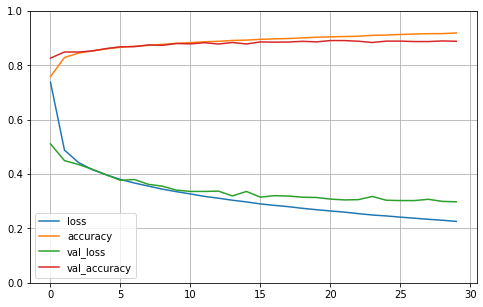

In [34]:
# 학습 곡선 시각화

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # y축 범위 0 ~ 1사이로 설정
plt.show()

In [35]:
# 모델 평가
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 991us/step - loss: 0.3315 - accuracy: 0.8830


[0.3314962685108185, 0.8830000162124634]

### 모델을 사용해 예측을 만들기

In [36]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [39]:
import numpy as np

y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [40]:
np.array(class_names)[y_pred]

# 잘 분류된것을 확인

array(['Ankle boot', 'Pullover', 'trouser'], dtype='<U11')

In [41]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

# 2. 시퀀셜 API를 사용하여 회귀용 다층 펍셉트론 만들기
- 캘리포니아 주택 가격 데이터셋으로 바꾸어 회귀 신경망으로 이를 해결

In [42]:
# 데이터를 적재한 후 훈련 세트, 검증 세트, 테스트 세트로 나누고 모든 특성이 스케일을 조정

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

#### 분류 방식과 비슷하나 차이점은 출력층이 활성화 함수가 없는 하나의 뉴런을 가진다는 것과 손실함수로 평균 제곰 오차를 사용한다는 것!


In [49]:
# 데이터셋에 잡음이 많기 때문에 과대적합을 막는 용도로 뉴런 수가 적은 은닉층 하나만 사용

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

# 모델 컴파일
model.compile(loss = "mean_squared_error", optimizer="sgd")

# 모델 학습
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

# 모델 평가
mse_test = model.evaluate(X_test, y_test)

# 테스트
X_new = X_test[:3]   # 새로운 샘플이라고 생각
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7661 - val_loss: 1.6374
Epoch 2/20
363/363 [==============================] - 0s 845us/step - loss: 1.7987 - val_loss: 0.7782
Epoch 3/20
363/363 [==============================] - 0s 904us/step - loss: 1.8798 - val_loss: 0.6436
Epoch 4/20
363/363 [==============================] - 0s 876us/step - loss: 0.4124 - val_loss: 0.6090
Epoch 5/20
363/363 [==============================] - 0s 865us/step - loss: 0.4043 - val_loss: 0.5222
Epoch 6/20
363/363 [==============================] - 0s 861us/step - loss: 0.3852 - val_loss: 0.5179
Epoch 7/20
363/363 [==============================] - 0s 846us/step - loss: 0.3725 - val_loss: 0.5109
Epoch 8/20
363/363 [==============================] - 0s 900us/step - loss: 0.3858 - val_loss: 0.5122
Epoch 9/20
363/363 [==============================] - 0s 841us/step - loss: 0.3892 - val_loss: 0.5279
Epoch 10/20
363/363 [==============================] - 0s 859us/step - loss: 0.3661 

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 함수형 API를 사용해 복잡한 모델 만들기
- 입력과 출력이 여러 개거나 더 복잡한 넽트워크 토폴로지를 갖는 신경망을 만들어야 할 때

## 와이드 & 딥 신경망 (Wide & Deep)
- 이 신경마은 같은 입력의 일부 또는 전체가 출력층에 바로 연결되는 구조
- 복잡한 패턴과 간단한 규칙을 모두 학습할 수 있는 구조
(데이터에 있는 간단한 패턴이 연속된 변환으로 인해 왜곡될 수 있음)

In [51]:
# 캘리포니아 주택 데이터셋

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_17 (Dense)               (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 30)           930         ['dense_17[0][0]']               
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_18[0][0]']           

In [53]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.0015 - val_loss: 0.8327
Epoch 2/20
363/363 [==============================] - 0s 915us/step - loss: 0.7612 - val_loss: 0.7165
Epoch 3/20
363/363 [==============================] - 0s 942us/step - loss: 0.6914 - val_loss: 0.6730
Epoch 4/20
363/363 [==============================] - 0s 956us/step - loss: 0.6535 - val_loss: 0.6411
Epoch 5/20
363/363 [==============================] - 0s 917us/step - loss: 0.6248 - val_loss: 0.6167
Epoch 6/20
363/363 [==============================] - 0s 947us/step - loss: 0.6006 - val_loss: 0.5997
Epoch 7/20
363/363 [==============================] - 0s 958us/step - loss: 0.5819 - val_loss: 0.5830
Epoch 8/20
363/363 [==============================] - 0s 945us/step - loss: 0.5648 - val_loss: 0.5651
Epoch 9/20
363/363 [==============================] - 0s 920us/step - loss: 0.5500 - val_loss: 0.5524
Epoch 10/20
363/363 [==============================] - 0s 951us/step - loss: 0.5384 

#### 여러개의 입력 다루기

In [55]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [56]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.7632 - val_loss: 0.8288
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7082 - val_loss: 0.6600
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6007 - val_loss: 0.6215
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5674 - val_loss: 0.5816
Epoch 5/20
363/363 [==============================] - 0s 978us/step - loss: 0.5439 - val_loss: 0.5588
Epoch 6/20
363/363 [==============================] - 0s 964us/step - loss: 0.5267 - val_loss: 0.5460
Epoch 7/20
363/363 [==============================] - 0s 998us/step - loss: 0.5123 - val_loss: 0.5239
Epoch 8/20
363/363 [==============================] - 0s 992us/step - loss: 0.5020 - val_loss: 0.5168
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4931 - val_loss: 0.5132
Epoch 10/20
363/363 [==============================] - 0s 989us/step - loss: 0.4833 - val_lo

#### 여러개의 출력 다루기

In [57]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])


In [58]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))


In [59]:
# 개별 손실과 총 손실을 반환

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0385 - main_output_loss: 1.7975 - aux_output_loss: 4.2074 - val_loss: 1.1518 - val_main_output_loss: 0.9056 - val_aux_output_loss: 3.3680
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.9710 - main_output_loss: 0.7744 - aux_output_loss: 2.7403 - val_loss: 0.8970 - val_main_output_loss: 0.7324 - val_aux_output_loss: 2.3780
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8002 - main_output_loss: 0.6628 - aux_output_loss: 2.0372 - val_loss: 0.7932 - val_main_output_loss: 0.6732 - val_aux_output_loss: 1.8730
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7220 - main_output_loss: 0.6144 - aux_output_loss: 1.6904 - val_loss: 0.7267 - val_main_output_loss: 0.6266 - val_aux_output_loss: 1.6281
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6767 - main_output_loss: 0.5826 - aux_output_loss: 1.5234 - val_loss

In [60]:
# 모델 평가
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 777us/step - loss: 0.5658 - main_output_loss: 0.5093 - aux_output_loss: 1.0745


# 서브클래싱 API로 동적 모델 만들기

In [61]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [62]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.5189 - output_1_loss: 2.3586 - output_2_loss: 3.9616 - val_loss: 1.5717 - val_output_1_loss: 1.3929 - val_output_2_loss: 3.1808
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 1.0098 - output_1_loss: 0.8569 - output_2_loss: 2.3861 - val_loss: 0.8806 - val_output_1_loss: 0.7459 - val_output_2_loss: 2.0924
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7751 - output_1_loss: 0.6656 - output_2_loss: 1.7602 - val_loss: 0.7588 - val_output_1_loss: 0.6567 - val_output_2_loss: 1.6773
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6939 - output_1_loss: 0.6073 - output_2_loss: 1.4735 - val_loss: 0.6906 - val_output_1_loss: 0.6050 - val_output_2_loss: 1.4606
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6451 - output_1_loss: 0.5696 - output_2_loss: 1.3253 - val_loss: 0.6484 - val_output_1_loss: 0.5711 - val_ou

## 모델 저장과 복원

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
]) 

In [64]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 2.5143 - val_loss: 1.5909
Epoch 2/10
363/363 [==============================] - 0s 887us/step - loss: 0.8626 - val_loss: 0.7180
Epoch 3/10
363/363 [==============================] - 0s 926us/step - loss: 0.6627 - val_loss: 0.6417
Epoch 4/10
363/363 [==============================] - 0s 870us/step - loss: 0.6113 - val_loss: 0.6003
Epoch 5/10
363/363 [==============================] - 0s 970us/step - loss: 0.5797 - val_loss: 0.5729
Epoch 6/10
363/363 [==============================] - 0s 884us/step - loss: 0.5558 - val_loss: 0.5508
Epoch 7/10
363/363 [==============================] - 0s 901us/step - loss: 0.5367 - val_loss: 0.5332
Epoch 8/10
363/363 [==============================] - 0s 865us/step - loss: 0.5205 - val_loss: 0.5185
Epoch 9/10
363/363 [==============================] - 0s 873us/step - loss: 0.5072 - val_loss: 0.5067
Epoch 10/10
162/162 [==============================] - 0s 609us/step - loss: 0.5523


In [65]:
# 모델 저장
model.save("my_keras_model.h5")

In [66]:
# 저장 모델 다시 불러오기

model = keras.models.load_model("my_keras_model.h5")

In [67]:
# 불러 온 모델로 예측하기
model.predict(X_new)

array([[1.6884105],
       [0.892621 ],
       [1.7517455]], dtype=float32)

## 콜백 사용하기
- fit() 메서드의 callback 매개변수를 사용하여 케라스가 훈련의 시작이나 끝에 호출할 객체리스트를 지정할 수 있음
- 또는 에포크의 시작이나 끝, 각 배치 처리전후에 호출 가능

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])   

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True) 
# save_best_only=True :최상의 검증 세트 점수만 모델에 저장

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.6857 - val_loss: 0.9632
Epoch 2/10
363/363 [==============================] - 0s 950us/step - loss: 0.8032 - val_loss: 0.7557
Epoch 3/10
363/363 [==============================] - 0s 965us/step - loss: 0.6960 - val_loss: 0.6744
Epoch 4/10
363/363 [==============================] - 0s 948us/step - loss: 0.6350 - val_loss: 0.6155
Epoch 5/10
363/363 [==============================] - 0s 995us/step - loss: 0.5905 - val_loss: 0.5729
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5549 - val_loss: 0.5400
Epoch 7/10
363/363 [==============================] - 0s 942us/step - loss: 0.5259 - val_loss: 0.5120
Epoch 8/10
363/363 [==============================] - 0s 965us/step - loss: 0.5022 - val_loss: 0.4920
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4832 - val_loss: 0.4755
Epoch 10/10
162/162 [==============================] - 0s 665us/step - loss: 0.5276


##### EarlyStopping :  일정 에포크동안 검증세트에 대한 점수가 향상되지 않으면 훈련 멈춤

In [71]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4542 - val_loss: 0.4474
Epoch 2/100
363/363 [==============================] - 0s 934us/step - loss: 0.4437 - val_loss: 0.4386
Epoch 3/100
363/363 [==============================] - 0s 994us/step - loss: 0.4347 - val_loss: 0.4353
Epoch 4/100
363/363 [==============================] - 0s 952us/step - loss: 0.4270 - val_loss: 0.4252
Epoch 5/100
363/363 [==============================] - 0s 965us/step - loss: 0.4205 - val_loss: 0.4207
Epoch 6/100
363/363 [==============================] - 0s 979us/step - loss: 0.4151 - val_loss: 0.4165
Epoch 7/100
363/363 [==============================] - 0s 950us/step - loss: 0.4100 - val_loss: 0.4114
Epoch 8/100
363/363 [==============================] - 0s 948us/step - loss: 0.4060 - val_loss: 0.4097
Epoch 9/100
363/363 [==============================] - 0s 947us/step - loss: 0.4022 - val_loss: 0.4066
Epoch 10/100
363/363 [==============================] - 0s 978us/step - los

Epoch 80/100
363/363 [==============================] - 0s 906us/step - loss: 0.3284 - val_loss: 0.3535
Epoch 81/100
363/363 [==============================] - 0s 995us/step - loss: 0.3279 - val_loss: 0.3530
Epoch 82/100
363/363 [==============================] - 0s 973us/step - loss: 0.3274 - val_loss: 0.3524
Epoch 83/100
363/363 [==============================] - 0s 898us/step - loss: 0.3271 - val_loss: 0.3529
Epoch 84/100
363/363 [==============================] - 0s 904us/step - loss: 0.3265 - val_loss: 0.3532
Epoch 85/100
363/363 [==============================] - 0s 895us/step - loss: 0.3264 - val_loss: 0.3524
Epoch 86/100
363/363 [==============================] - 0s 901us/step - loss: 0.3259 - val_loss: 0.3527
Epoch 87/100
363/363 [==============================] - 0s 921us/step - loss: 0.3257 - val_loss: 0.3519
Epoch 88/100
363/363 [==============================] - 0s 932us/step - loss: 0.3251 - val_loss: 0.3515
Epoch 89/100
363/363 [==============================] - 0s 951us

# 텐서보드를 사용해 시각화하기

In [72]:
import os

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")  # 예 :my_logs/run_201906_07-15_15_22
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_12_17-17_03_54'

In [73]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 2.0560 - val_loss: 1.0893
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.8199 - val_loss: 0.7025
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6441 - val_loss: 0.6099
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5758 - val_loss: 0.5641
Epoch 5/30
363/363 [==============================] - 0s 991us/step - loss: 0.5398 - val_loss: 0.5354
Epoch 6/30
363/363 [==============================] - 0s 967us/step - loss: 0.5142 - val_loss: 0.5148
Epoch 7/30
363/363 [==============================] - 0s 997us/step - loss: 0.4956 - val_loss: 0.4971
Epoch 8/30
363/363 [==============================] - 0s 984us/step - loss: 0.4798 - val_loss: 0.4837
Epoch 9/30
363/363 [==============================] - 0s 918us/step - loss: 0.4672 - val_loss: 0.4719
Epoch 10/30
363/363 [==============================] - 0s 923us/step - loss: 0.4562 - val_

In [74]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2